In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config["database.host"] = '134.2.168.16'
dj.config['schema_name'] = "nnfabrik_monkey_mei"
schema = dj.schema("nnfabrik_monkey_mei")

import os
from os import listdir
from os.path import isfile, join

import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.from_nnfabrik import DataInfo

Connecting DKessler@134.2.168.16:3306


In [2]:
import insilico_stimuli
from insilico_stimuli.stimuli_parameter import BarsSet, GaborSet, PlaidsGaborSet, DiffOfGaussians, CenterSurround, PlaidsGratingSet
from insilico_stimuli.parameters import *

In [3]:
# nnfabrik main
from nnvision.tables.main import MonkeyExperiment
from nnvision.tables.from_mei import TrainedEnsembleModel, MEIMethod
from featurevis.main import MEITemplate
from nnvision.tables.measures import OracleScore

@schema
class MEI_update(MEITemplate):
    trained_model_table = TrainedEnsembleModel
    selector_table = MonkeyExperiment.Units

# Load the model

In [4]:
# loading model
ensemble_hash='e7a8d0b961ee37ffda0779bfed95f1cf'

model_key = (TrainedModel * TrainedEnsembleModel.Member() & dict(ensemble_hash=ensemble_hash)).fetch("KEY", limit=1, order_by="score DESC")
model = TrainedModel().load_model(model_key, include_dataloader=False)
model.eval()

Encoder(
  (core): SE2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 32, kernel_size=(24, 24), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(8, 8), dilation=(2, 2), groups=32, bias=False)
          (out_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
        (seg_ex_block): SQ_EX_Block(
          (se): Sequential(
     

In [5]:
# canvas size
h = 41
w = 41
canvas_size = [w, h]

In [6]:
data_key='3631807112901'                   # model specifics for optimization
n_units = model.readout[data_key].outdims  # number of model neurons 
total_trials = 30                          # for optimization
unit_idx = 27                              # arbitrary model neuron

# model readout coordinates from -1, 1 
model.readout[data_key].grid  # needs to be converted to canvas size by min-max-normalization

Parameter containing:
tensor([[[[-0.0482,  0.0579]],

         [[-0.2883,  0.0565]],

         [[-0.2923,  0.1154]],

         [[ 0.0009,  0.0505]],

         [[-0.0600, -0.0448]],

         [[-0.2938,  0.1244]],

         [[-0.2965,  0.3931]],

         [[-0.1132,  0.4247]],

         [[ 0.0509,  0.3379]],

         [[-0.2086,  0.3161]],

         [[-0.3293,  0.0871]],

         [[-0.2918,  0.3593]],

         [[-0.0455,  0.0573]],

         [[-0.2696,  0.3134]],

         [[-0.1766,  0.2250]],

         [[-0.1001,  0.0033]],

         [[-0.0216,  0.0470]],

         [[-0.3051,  0.2617]],

         [[-0.2893,  0.0936]],

         [[-0.1083,  0.3236]],

         [[-0.0547,  0.3937]],

         [[-0.2828,  0.1749]],

         [[-0.2872,  0.0415]],

         [[-0.2872,  0.2713]],

         [[-0.2916,  0.2917]],

         [[-0.2930,  0.0860]],

         [[-0.2917,  0.0071]],

         [[-0.2687,  0.3289]],

         [[ 0.0141,  0.4193]]]], requires_grad=True)

# Bar Stimulus

In [7]:
# FiniteParameter -> bar_set1
locations    = FiniteParameter([[20.2, 20.2]])
lengths      = FiniteParameter([5.0])
widths       = FiniteParameter([2.0])
contrasts    = FiniteParameter([-1]) 
orientations = FiniteParameter([0.0, np.pi/4, np.pi/2]) 
grey_levels  = FiniteParameter([0.0])

# class object
bar_set1 = BarsSet(canvas_size=canvas_size,
                   locations=locations,
                   lengths=lengths,
                   widths=widths,
                   contrasts=contrasts,
                   orientations=orientations,
                   grey_levels=grey_levels)

In [8]:
print(bar_set1.canvas_size)
print(bar_set1.locations)
print(bar_set1.lengths)
print(bar_set1.widths)
print(bar_set1.contrasts)
print(bar_set1.orientations)
print(bar_set1.grey_levels)
print(bar_set1.pixel_boundaries)

[41, 41]
[[20.2, 20.2]]
[5.0]
[2.0]
[-1]
[0.0, 0.7853981633974483, 1.5707963267948966]
[0.0]
[-1, 1]


In [9]:
# with lists -> bar_set2
locations    = [[20, 20], [20, 20]]
lengths      = [11.0]
widths       = [5.0]
contrasts    = [-1] 
orientations = [np.pi/4, np.pi/2] 
grey_levels  = [0.0]

# class object
bar_set2 = BarsSet(canvas_size=canvas_size,
                   locations=locations,
                   lengths=lengths,
                   widths=widths,
                   contrasts=contrasts,
                   orientations=orientations,
                   grey_levels=grey_levels)

In [10]:
print(bar_set2.canvas_size)
print(bar_set2.locations)
print(bar_set2.lengths)
print(bar_set2.widths)
print(bar_set2.contrasts)
print(bar_set2.orientations)
print(bar_set2.grey_levels)
print(bar_set2.pixel_boundaries)

[41, 41]
[[20, 20], [20, 20]]
[11.0]
[5.0]
[-1]
[0.7853981633974483, 1.5707963267948966]
[0.0]
[-1, 1]


In [11]:
# FiniteSelection -> bar_set3
np.random.seed(None)
locations    = FiniteSelection([[20, 20], [20, 20]])
lengths      = FiniteSelection([5.0, 7.0])
widths       = FiniteSelection([2.0, 3.0])
contrasts    = FiniteSelection([-1, 1]) 
orientations = FiniteSelection([0.0, np.pi/4, np.pi/2]) 
grey_levels  = FiniteSelection([0.0, 0.5])

# class object
bar_set3 = BarsSet(canvas_size=canvas_size,
                   locations=locations,
                   lengths=lengths,
                   widths=widths,
                   contrasts=contrasts,
                   orientations=orientations,
                   grey_levels=grey_levels)

In [12]:
print(bar_set3.canvas_size)
print(bar_set3.locations)
print(bar_set3.lengths)
print(bar_set3.widths)
print(bar_set3.contrasts)
print(bar_set3.orientations)
print(bar_set3.grey_levels)
print(bar_set3.pixel_boundaries)

[41, 41]
[[20, 20]]
[7.0]
[3.0]
[-1]
[0.0]
[0.0]
[-1, 1]


In [13]:
# UniformRange -> bar_set4
np.random.seed(None)
locations    = UniformRange([[10, 30], [10, 30]])
lengths      = UniformRange([10.0, 20.0])
widths       = UniformRange([2.0, 9.0])
contrasts    = UniformRange([-1.0, 1.0]) 
orientations = UniformRange([0.0, np.pi/2]) 
grey_levels  = FiniteParameter([0.0])

# class object
bar_set4 = BarsSet(canvas_size=canvas_size,
                   locations=locations,
                   lengths=lengths,
                   widths=widths,
                   contrasts=contrasts,
                   orientations=orientations,
                   grey_levels=grey_levels)

In [14]:
print("Samples:", bar_set4.canvas_size, bar_set4.locations, bar_set4.lengths, bar_set4.widths, bar_set4.contrasts, bar_set4.orientations, bar_set4.grey_levels, bar_set4.pixel_boundaries)
print("Ranges:", bar_set4.locations_range, bar_set4.lengths_range, bar_set4.widths_range, bar_set4.contrasts_range, bar_set4.orientations_range)

Samples: [41, 41] [[22.758172076915457, 13.220834869623832]] [12.179220959346221] [7.7854879065932385] [-0.02066273500361837] [1.4205014540588274] [0.0] [-1, 1]
Ranges: [[10, 30], [10, 30]] [10.0, 20.0] [2.0, 9.0] [-1.0, 1.0] [0.0, 1.5707963267948966]


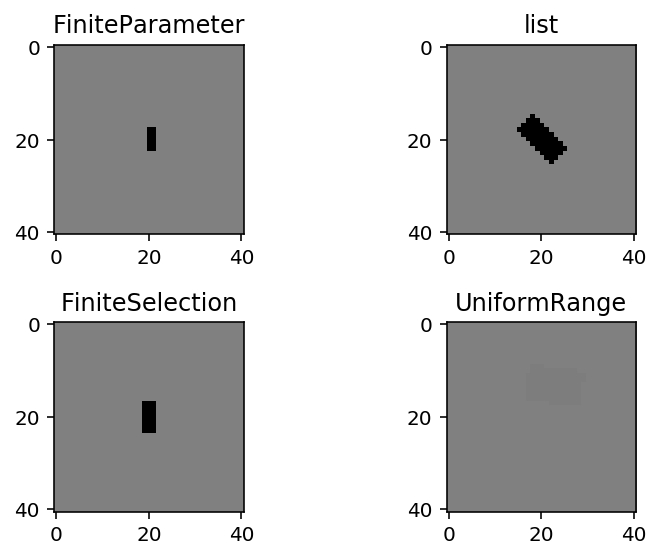

In [15]:
plt.subplot(221)
plt.imshow(bar_set1.stimulus_from_idx(0), cmap="gray", vmin=-1, vmax=1)
plt.title("FiniteParameter")

plt.subplot(222)
plt.imshow(bar_set2.stimulus_from_idx(0), cmap="gray", vmin=-1, vmax=1)
plt.title("list")

plt.subplot(223)
plt.imshow(bar_set3.stimulus_from_idx(0), cmap="gray", vmin=-1, vmax=1)
plt.title("FiniteSelection")

plt.subplot(224)
plt.imshow(bar_set4.stimulus_from_idx(0), cmap="gray", vmin=-1, vmax=1)
plt.title("UniformRange")

plt.tight_layout()

In [16]:
best_bar4_params, best_bar4_values = bar_set4.find_optimal_stimulus_bayes(model=model, data_key=data_key, unit_idx=unit_idx)

[INFO 10-19 03:45:03] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 7 trials, GPEI for subsequent trials]). Iterations after 7 will take longer to generate due to  model-fitting.
[INFO 10-19 03:45:03] ax.service.managed_loop: Started full optimization with 30 steps.
[INFO 10-19 03:45:03] ax.service.managed_loop: Running optimization trial 1...
[INFO 10-19 03:45:03] ax.service.managed_loop: Running optimization trial 2...
[INFO 10-19 03:45:03] ax.service.managed_loop: Running optimization trial 3...
[INFO 10-19 03:45:03] ax.service.managed_loop: Running optimization trial 4...
[INFO 10-19 03:45:04] ax.service.managed_loop: Running optimization trial 5...
[INFO 10-19 03:45:04] ax.service.managed_loop: Running optimization trial 6...
[INFO 10-19 03:45:04] ax.service.managed_loop: Running optimization trial 7...
[INFO 10-19 03:45:04] ax.service.managed_loop: Running optimization trial 8...
[INFO 10-19 

In [17]:
bar4_stim_opt = bar_set4.get_image_from_params(best_bar4_params)

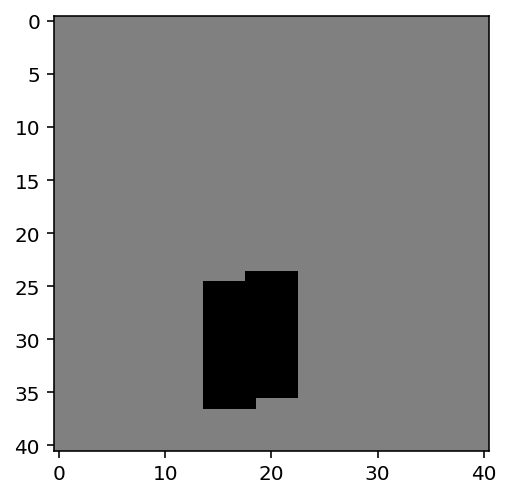

In [18]:
plt.imshow(bar4_stim_opt, cmap="gray", vmin=-1, vmax=1)

In [19]:
print(best_bar4_params)

{'location_width': 18, 'location_height': 30, 'length': 12.048327777115162, 'width': 8.999999190890502, 'contrast': -1.0, 'orientation': 0.06866508843119044, 'grey_level': 0.0}


# Toy Experiment: Increase Bar size and look for surround supression

# Gabor class

In [20]:
# case 1: FiniteParameter class -> gabor_set1

# Choose the input parameters
canvas_size         = [w, h]
sizes               = FiniteParameter([10.0, 20.0])
spatial_frequencies = FiniteParameter([1/20, 1/5])
contrasts           = FiniteParameter([0.5, 0.75, 1.0])
grey_levels         = FiniteParameter([0.0])
eccentricities      = FiniteParameter([0.0, 0.9])
locations           = FiniteParameter([[25.0, 30.0]])

orientation_values = [val * (np.pi) / 8 for val in range(0, 8)]  
orientations = FiniteParameter(orientation_values)

phase_values = [val * (2*np.pi) / 8 for val in range(0, 8)]
phases = FiniteParameter(phase_values)

In [21]:
# Instantiate the Gabor class
gabor_set1 = GaborSet(canvas_size=canvas_size,
                      sizes=sizes,
                      spatial_frequencies=spatial_frequencies,
                      contrasts=contrasts,
                      orientations=orientations,
                      phases=phases, 
                      grey_levels=grey_levels,
                      eccentricities=eccentricities,
                      locations=locations,
                      relative_sf=False)

In [23]:
gabor_set1.arg_dict

{'self': <insilico_stimuli.stimuli_parameter.GaborSet at 0x7f79243a8990>,
 'canvas_size': [41, 41],
 'locations': <insilico_stimuli.parameters.FiniteParameter at 0x7f79243ace50>,
 'sizes': <insilico_stimuli.parameters.FiniteParameter at 0x7f79243ac0d0>,
 'spatial_frequencies': <insilico_stimuli.parameters.FiniteParameter at 0x7f79243acc90>,
 'contrasts': <insilico_stimuli.parameters.FiniteParameter at 0x7f79243ac450>,
 'orientations': <insilico_stimuli.parameters.FiniteParameter at 0x7f79243acc50>,
 'phases': <insilico_stimuli.parameters.FiniteParameter at 0x7f79243ac890>,
 'grey_levels': <insilico_stimuli.parameters.FiniteParameter at 0x7f79243ac7d0>,
 'eccentricities': <insilico_stimuli.parameters.FiniteParameter at 0x7f79243acd10>,
 'pixel_boundaries': None,
 'relative_sf': False}

In [24]:
# Generate the images 
gabor_set1.auto_params

{'location_width': {'name': 'location_width', 'type': 'fixed', 'value': 25.0},
 'location_height': {'name': 'location_height',
  'type': 'fixed',
  'value': 30.0},
 'size': {'name': 'size', 'type': 'choice', 'values': [10.0, 20.0]},
 'spatial_frequency': {'name': 'spatial_frequency',
  'type': 'choice',
  'values': [0.05, 0.2]},
 'contrast': {'name': 'contrast',
  'type': 'choice',
  'values': [0.5, 0.75, 1.0]},
 'orientation': {'name': 'orientation',
  'type': 'choice',
  'values': [0.0,
   0.39269908169872414,
   0.7853981633974483,
   1.1780972450961724,
   1.5707963267948966,
   1.9634954084936207,
   2.356194490192345,
   2.748893571891069]},
 'phase': {'name': 'phase',
  'type': 'choice',
  'values': [0.0,
   0.7853981633974483,
   1.5707963267948966,
   2.356194490192345,
   3.141592653589793,
   3.9269908169872414,
   4.71238898038469,
   5.497787143782138]},
 'gamma': {'name': 'gamma',
  'type': 'choice',
  'values': [1.0, 0.18999999999999995]},
 'grey_level': {'name': 'grey_l

In [26]:
# Find the best among all defined gabor images (via Bayesian Search), for one specific model neuron
unit_idx = 27
best_gabor1_params_bayes, values_gabor1_bayes = gabor_set1.find_optimal_stimulus_bayes(model = model, 
                                                                                       data_key = data_key,
                                                                                       unit_idx = unit_idx,
                                                                                       total_trials = total_trials)

[INFO 10-19 03:08:14] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 10-19 03:08:14] ax.service.managed_loop: Started full optimization with 30 steps.
[INFO 10-19 03:08:14] ax.service.managed_loop: Running optimization trial 1...
[INFO 10-19 03:08:14] ax.service.managed_loop: Running optimization trial 2...
[INFO 10-19 03:08:14] ax.service.managed_loop: Running optimization trial 3...
[INFO 10-19 03:08:14] ax.service.managed_loop: Running optimization trial 4...
[INFO 10-19 03:08:14] ax.service.managed_loop: Running optimization trial 5...
[INFO 10-19 03:08:14] ax.service.managed_loop: Running optimization trial 6...
[INFO 10-19 03:08:15] ax.service.managed_loop: Running optimization trial 7...
[INFO 10-19 03:08:15] ax.service.managed_loop: Running optimization trial 8...
[INFO 10-19 03:08:15] ax.service.managed_loop: Running optimization trial 9...
[INFO 10-19 03:08:15] ax.service.managed_loop: Running optimization trial 10...
[INFO 10-19 03:08:15] ax.service.ma

In [27]:
# best gabor for all model neurons
best_gabor1_params_bayes = []
values_gabor1_bayes = []
for unit in range(0, n_units):
    best_params, values = gabor_set1.find_optimal_stimulus_bayes(model = model, 
                                                                data_key = data_key,
                                                                unit_idx = unit, 
                                                                total_trials = total_trials)
    best_gabor1_params_bayes.append(best_params)
    values_gabor1_bayes.append(values)

[INFO 10-19 03:08:32] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 10-19 03:08:32] ax.service.managed_loop: Started full optimization with 30 steps.
[INFO 10-19 03:08:32] ax.service.managed_loop: Running optimization trial 1...
[INFO 10-19 03:08:32] ax.service.managed_loop: Running optimization trial 2...
[INFO 10-19 03:08:32] ax.service.managed_loop: Running optimization trial 3...
[INFO 10-19 03:08:32] ax.service.managed_loop: Running optimization trial 4...
[INFO 10-19 03:08:32] ax.service.managed_loop: Running optimization trial 5...
[INFO 10-19 03:08:32] ax.service.managed_loop: Running optimization trial 6...
[INFO 10-19 03:08:32] ax.service.managed_loop: Running optimization trial 7...
[INFO 10-19 03:08:32] ax.service.managed_loop: Running optimization trial 8...
[INFO 10-19 03:08:32] ax.service.managed_loop: Running optimization trial 9...
[INFO 10-19 03:08:33] ax.service.managed_loop: Running optimization trial 10...
[INFO 10-19 03:08:33] ax.service.ma

In [28]:
print(best_gabor1_params_bayes[0])

{'size': 20.0, 'spatial_frequency': 0.05, 'contrast': 0.75, 'orientation': 2.356194490192345, 'phase': 4.71238898038469, 'gamma': 0.18999999999999995, 'location_width': 25.0, 'location_height': 30.0, 'grey_level': 0.0}


In [29]:
# Find the best among all defined gabor images (via BruteForce Search)
best_gabor1_params_bf, values_gabor1_bf = gabor_set1.find_optimal_stimulus_bruteforce(model = model, 
                                                                                      data_key = data_key, 
                                                                                      batch_size = 100, 
                                                                                      return_activations = False, 
                                                                                      unit_idx = None,
                                                                                      plotflag = False)

In [34]:
# try different types of input arguments (hybrid example with some "finite" and some "infinite" parameter sets)
canvas_size         = [w, h]
sizes               = UniformRange([10.0, 40.0])
spatial_frequencies = UniformRange([1/40, 1/5])
contrasts           = FiniteParameter([0.5, 0.75, 1.0])
orientations        = UniformRange([0.0, np.pi])
phases              = UniformRange([0.0, 2*np.pi])
grey_levels         = FiniteParameter([0.0])
eccentricities      = UniformRange([0.0, 0.9])

# search on every pixel except the ones too far at the image corners
locs = [[float(w), float(h)] for w in range(0 + 8, 41 - 8)
               for h in range(0 + 8, 41 - 8)]
locations = FiniteParameter(locs)

In [35]:
# do Bayesian Search again with new parameter set

gabor_set2 = GaborSet(canvas_size=canvas_size,
                      sizes=sizes,
                      spatial_frequencies=spatial_frequencies,
                      contrasts=contrasts,
                      orientations=orientations,
                      phases=phases, 
                      grey_levels=grey_levels,
                      eccentricities=eccentricities,
                      locations=locations,
                      relative_sf=False)

# for all model neurons
best_gabor2_params_list = []
values_gabor2_list = []
for unit in range(0, n_units):
    best_params, values = gabor_set2.find_optimal_stimulus_bayes(model = model, 
                                                                 data_key = data_key,
                                                                 unit_idx = unit, 
                                                                 total_trials = total_trials)
    best_gabor2_params_list.append(best_params)
    values_gabor2_list.append(values)

[INFO 10-19 03:12:24] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 10-19 03:12:24] ax.service.managed_loop: Started full optimization with 30 steps.
[INFO 10-19 03:12:24] ax.service.managed_loop: Running optimization trial 1...
[INFO 10-19 03:12:24] ax.service.managed_loop: Running optimization trial 2...
[INFO 10-19 03:12:24] ax.service.managed_loop: Running optimization trial 3...
[INFO 10-19 03:12:24] ax.service.managed_loop: Running optimization trial 4...
[INFO 10-19 03:12:24] ax.service.managed_loop: Running optimization trial 5...
[INFO 10-19 03:12:24] ax.service.managed_loop: Running optimization trial 6...
[INFO 10-19 03:12:24] ax.service.managed_loop: Running optimization trial 7...
[INFO 10-19 03:12:25] ax.service.managed_loop: Running optimization trial 8...
[INFO 10-19 03:12:25] ax.service.managed_loop: Running optimization trial 9...
[INFO 10-19 03:12:25] ax.service.managed_loop: Running optimization trial 10...
[INFO 10-19 03:12:25] ax.service.ma

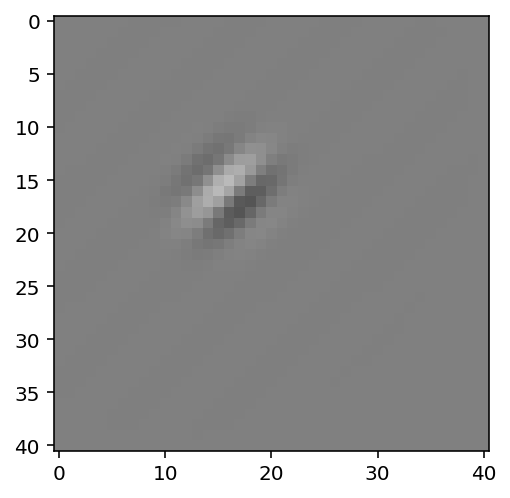

In [39]:
gabor2_stim = gabor_set2.get_image_from_params(best_gabor2_params_list[0])
plt.imshow(gabor2_stim, cmap="gray", vmin=-1, vmax=1)

In [19]:
gabor_set1.contrasts

[0.5, 0.75, 1.0]

# Plaids class

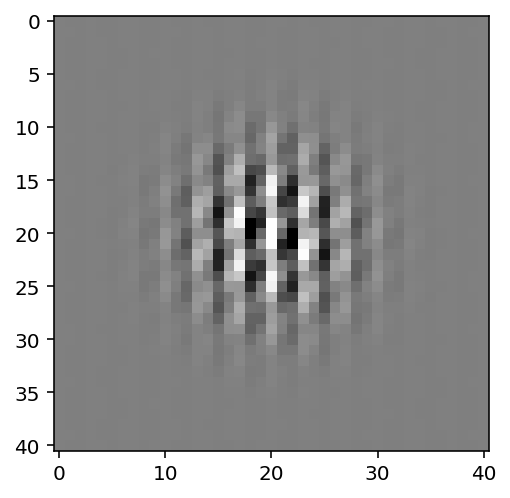

In [40]:
# choose parameter configuration
# Choose the input parameters
canvas_size         = [w, h]
locations           = FiniteParameter([[20.0, 20.0]])
sizes               = FiniteParameter([20.0])
spatial_frequencies = FiniteParameter([3/10, 4/10, 5/10])
orientations        = FiniteParameter(list(np.arange(0, np.pi, np.pi/8)))
phases              = FiniteParameter([0.0])
contrasts_preferred = FiniteParameter([0.5, 0.75, 1.0])
contrasts_overlap   = FiniteParameter([0.5, 0.75, 1.0])
grey_levels         = FiniteParameter([0.0])
angles              = FiniteParameter(list(np.arange(0, np.pi, np.pi/8)))

# instantiate plaids class
plaids_set1 = PlaidsGaborSet(canvas_size=canvas_size, 
                             locations=locations,
                             sizes=sizes,
                             spatial_frequencies=spatial_frequencies,
                             orientations=orientations,
                             phases=phases,
                             contrasts_preferred=contrasts_preferred,
                             contrasts_overlap=contrasts_overlap, 
                             grey_levels=grey_levels, 
                             angles=angles)

# plot one of the generated images
plt.imshow(plaids_set1.stimulus_from_idx(54), cmap='gray', vmin=-1, vmax=1)

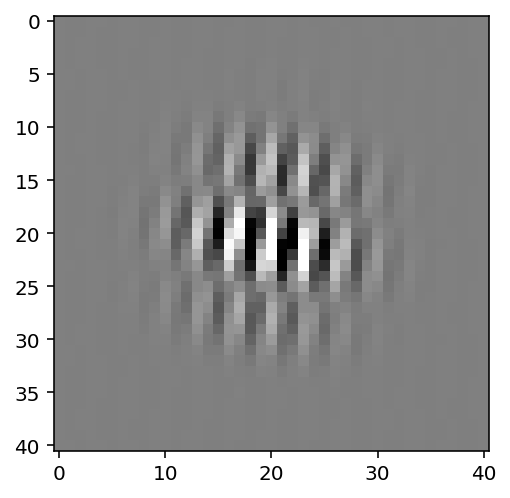

In [41]:
# random plaid (sampled from finite selection, without pmf)
canvas_size         = [w, h]
locations           = FiniteSelection([[20,20]])
sizes               = FiniteSelection([20])
spatial_frequencies = FiniteSelection([3/10, 4/10, 5/10])
orientations        = FiniteSelection(list(np.arange(0, np.pi, np.pi/8)))
phases              = FiniteSelection(list(np.arange(0, 2*np.pi, np.pi/8)))
contrasts_preferred = FiniteSelection([0.5, 0.75, 1.0])
contrasts_overlap   = FiniteSelection([0.5, 0.75, 1.0])
grey_levels         = FiniteSelection([0.0])
angles              = FiniteSelection(list(np.arange(0, np.pi, np.pi/8)))

# instantiate plaids class
plaids_set2 = PlaidsGaborSet(canvas_size = [41, 41], 
                             locations=locations,
                             sizes=sizes,
                             spatial_frequencies=spatial_frequencies,
                             orientations=orientations,
                             phases=phases,
                             contrasts_preferred=contrasts_preferred,
                             contrasts_overlap=contrasts_overlap, 
                             grey_levels=grey_levels, 
                             angles=angles)

# plot the generated image
plt.imshow(plaids_set2.stimulus_from_idx(0), cmap='gray', vmin=-1, vmax=1)

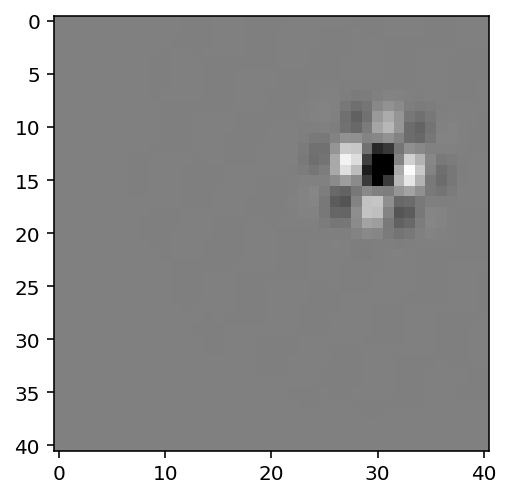

In [42]:
# random plaid (sampled from parameter range, without pseudo_inverse density)
canvas_size         = [w, h]
locations           = UniformRange([[8, 34], [8, 34]])
sizes               = UniformRange([10, 40])
spatial_frequencies = UniformRange([1/80, 4/10])
orientations        = UniformRange([0, np.pi])
phases              = UniformRange([0, 2*np.pi])
contrasts_preferred = UniformRange([0.5, 1.0])
contrasts_overlap   = UniformRange([0.5, 1.0])
grey_levels         = FiniteParameter([0.0])
angles              = UniformRange([0, np.pi])

# instantiate plaids class
plaids_set3 = PlaidsGaborSet(canvas_size = [41, 41], 
                             locations=locations,
                             sizes=sizes,
                             spatial_frequencies=spatial_frequencies,
                             orientations=orientations,
                             phases=phases,
                             contrasts_preferred=contrasts_preferred,
                             contrasts_overlap=contrasts_overlap, 
                             grey_levels=grey_levels, 
                             angles=angles)

# plot the generated image
plt.imshow(plaids_set3.stimulus_from_idx(0), cmap='gray', vmin=-1, vmax=1)

# DiffOfGaussian class

In [43]:
# UniformRange: DoG1
canvas_size              = [w, h]
locations                = UniformRange([[15.0, 35.0], [15.0, 35.0]])
sizes                    = UniformRange([10.0, 35.0])
sizes_scale_surround     = UniformRange([1.01, 2.0])
contrasts                = UniformRange([-1.0, 1.0])
contrasts_scale_surround = UniformRange([0.0, 1.0])
grey_levels              = FiniteParameter([0.0])

DoG1 = DiffOfGaussians(canvas_size=canvas_size, 
                       locations=locations,
                       sizes=sizes,
                       sizes_scale_surround=sizes_scale_surround,
                       contrasts=contrasts,
                       contrasts_scale_surround=contrasts_scale_surround, 
                       grey_levels=grey_levels)
                       #pixel_boundaries=None)

In [44]:
# find optimal DoG stimulus for the given infinite parameter set
unit_idx=25
best_DoG1_params, values_DoG1 = DoG1.find_optimal_stimulus(model = model, 
                                                           data_key = data_key,
                                                           unit_idx = unit_idx,
                                                           total_trials=30)

[INFO 10-19 03:17:08] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 7 trials, GPEI for subsequent trials]). Iterations after 7 will take longer to generate due to  model-fitting.
[INFO 10-19 03:17:08] ax.service.managed_loop: Started full optimization with 30 steps.
[INFO 10-19 03:17:08] ax.service.managed_loop: Running optimization trial 1...
[INFO 10-19 03:17:08] ax.service.managed_loop: Running optimization trial 2...
[INFO 10-19 03:17:08] ax.service.managed_loop: Running optimization trial 3...
[INFO 10-19 03:17:08] ax.service.managed_loop: Running optimization trial 4...
[INFO 10-19 03:17:08] ax.service.managed_loop: Running optimization trial 5...
[INFO 10-19 03:17:08] ax.service.managed_loop: Running optimization trial 6...
[INFO 10-19 03:17:08] ax.service.managed_loop: Running optimization trial 7...
[INFO 10-19 03:17:08] ax.service.managed_loop: Running optimization trial 8...
[INFO 10-19 

In [45]:
print(best_DoG1_params)

{'location_width': 19.109269966927627, 'location_height': 29.012146644552033, 'size': 10.0, 'size_scale_surround': 1.4510853222056168, 'contrast': -1.0, 'contrast_scale_surround': 0.8229098345774988, 'grey_level': 0.0}


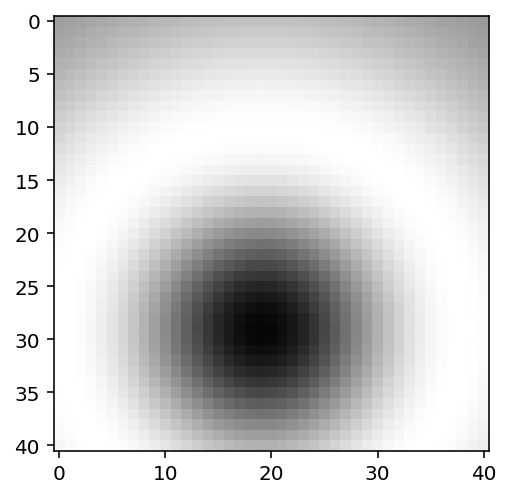

In [46]:
plt.imshow(DoG1.get_image_from_params(best_DoG1_params), cmap="gray", vmin=-1, vmax=1)

# Center Surround class

In [53]:
# Hybrid Parameter types
canvas_size                = [w, h]
locations                  = FiniteParameter([[20.0, 20.0]])
sizes_total                = FiniteParameter([13.0])
sizes_center               = FiniteParameter([0.7])
sizes_surround             = FiniteParameter([0.7])
contrasts_center           = FiniteSelection([0.75, 1.0])
contrasts_surround         = FiniteParameter([0.75])
orientations_center        = UniformRange([0, np.pi], n=8)
orientations_surround      = UniformRange([0, np.pi])
spatial_frequencies_center = FiniteParameter([0.2])
phases_center              = UniformRange([0.0, 2*np.pi])
grey_levels                = FiniteParameter([0.0])

# call center-surround
cs1 = CenterSurround(canvas_size=canvas_size, 
                     locations=locations,
                     sizes_total=sizes_total,
                     sizes_center=sizes_center,
                     sizes_surround=sizes_surround,
                     contrasts_center=contrasts_center,
                     contrasts_surround=contrasts_surround,
                     orientations_center=orientations_center,
                     orientations_surround=orientations_surround,
                     spatial_frequencies_center=spatial_frequencies_center,
                     phases_center=phases_center,
                     grey_levels=grey_levels)
               

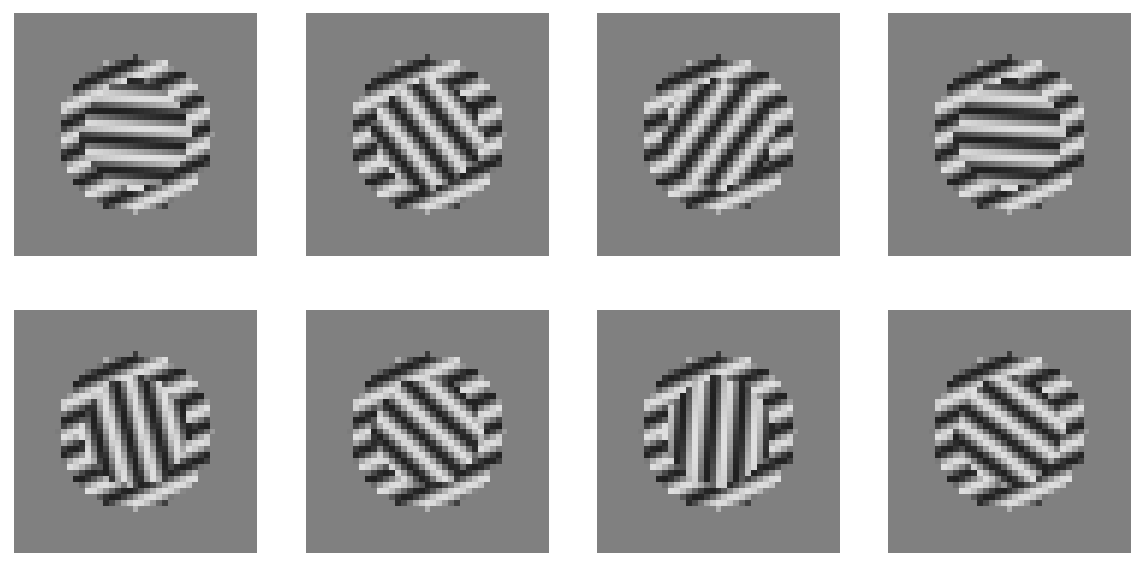

In [54]:
plt.figure(figsize=(10, 5))

for i, img in enumerate(cs1.images()):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img.T, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')

In [62]:
# managing to have a gap in between the center and surround 
canvas_size                = [w, h]
locations                  = [[20.0, 20.0]]
sizes_total                = [13.0]
sizes_center               = [0.7]
sizes_surround             = [0.8]
contrasts_center           = [0.0, 1.0]
contrasts_surround         = [1.0]
orientations_center        = [val * (np.pi) / 8 for val in range(0, 8)]
orientations_surround      = [np.pi]
spatial_frequencies_center = [0.2]
phases_center              = UniformRange([0.0, 2*np.pi])
grey_levels                = [0.0]

# call center-surround
cs2 = CenterSurround(canvas_size=canvas_size, 
                     locations=locations,
                     sizes_total=sizes_total,
                     sizes_center=sizes_center,
                     sizes_surround=sizes_surround,
                     contrasts_center=contrasts_center,
                     contrasts_surround=contrasts_surround,
                     orientations_center=orientations_center,
                     orientations_surround=orientations_surround,
                     spatial_frequencies_center=spatial_frequencies_center,
                     phases_center=phases_center,
                     grey_levels=grey_levels)
               

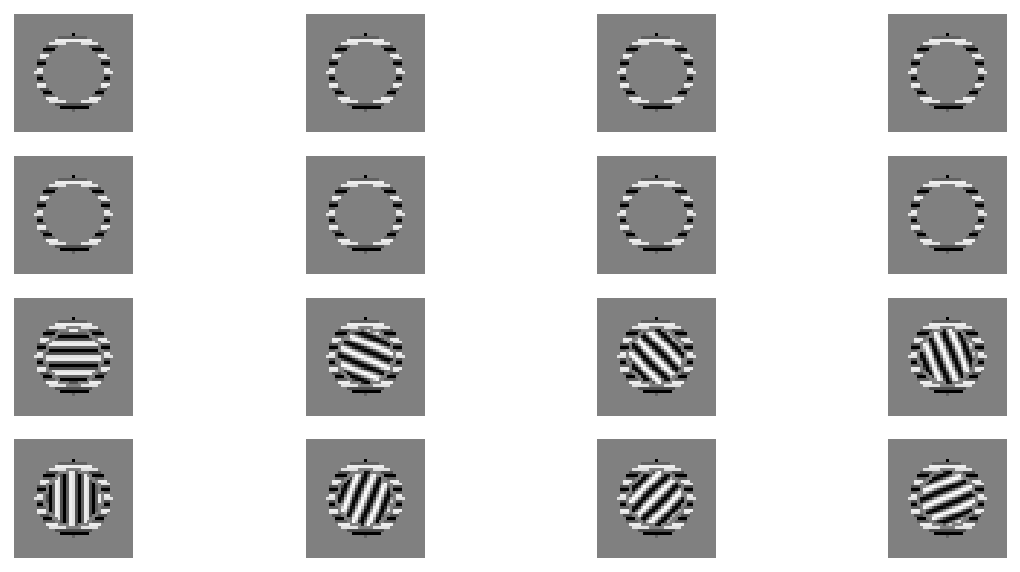

In [63]:
plt.figure(figsize=(10, 5))

for i, img in enumerate(cs2.images()):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img.T, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')

# PlaidsGrating class

In [64]:
# FiniteParameter: plaid_grating1
canvas_size          = [w, h]
locations            = FiniteParameter([[20.0, 20.0]])
sizes_total          = FiniteParameter([10.0])
#spatial_frequencies  = FiniteParameter([0.3])
spatial_frequencies  = FiniteParameter([0.1])
orientations         = FiniteParameter([0.0])
phases               = FiniteParameter([0.0])
contrasts_preferred  = FiniteParameter([0.5, 0.75, 1.0])
contrasts_overlap    = FiniteParameter([0.5, 0.75, 1.0])
grey_levels          = FiniteParameter([0.0])
angles               = FiniteParameter(list(np.arange(0, np.pi, np.pi/8)))
#angles               = FiniteParameter([np.pi/2])

plaid_grating1 = PlaidsGratingSet(canvas_size=canvas_size, 
                                  sizes_total=sizes_total,
                                  locations=locations,
                                  contrasts_preferred=contrasts_preferred,
                                  contrasts_overlap=contrasts_overlap, 
                                  spatial_frequencies=spatial_frequencies,
                                  orientations=orientations,
                                  phases=phases,
                                  grey_levels=grey_levels, 
                                  angles=angles,
                                  #angles = None,
                                  pixel_boundaries=None)

In [65]:
# FiniteSelection: plaid_grating2
canvas_size         = [w, h]
locations           = FiniteSelection([[20,20]])
sizes               = FiniteSelection([20])
spatial_frequencies = FiniteSelection([3/10, 4/10, 5/10])
orientations        = FiniteSelection(list(np.arange(0, np.pi, np.pi/8)))
phases              = FiniteSelection(list(np.arange(0, 2*np.pi, np.pi/8)))
contrasts_preferred = FiniteSelection([0.5, 0.75, 1.0])
contrasts_overlap   = FiniteSelection([0.5, 0.75, 1.0])
grey_levels         = FiniteSelection([0.0])
angles              = FiniteSelection(list(np.arange(0, np.pi, np.pi/8)))

plaid_grating2 = PlaidsGratingSet(canvas_size=canvas_size, 
                                  sizes_total=sizes_total,
                                  locations=locations,
                                  contrasts_preferred=contrasts_preferred,
                                  contrasts_overlap=contrasts_overlap, 
                                  spatial_frequencies=spatial_frequencies,
                                  orientations=orientations,
                                  phases=phases,
                                  grey_levels=grey_levels, 
                                  angles=angles,
                                  pixel_boundaries=None)

In [66]:
# UniformRange: plaid_grating3
canvas_size         = [w, h]
locations           = UniformRange([[8, 34], [8, 34]])
sizes               = UniformRange([10, 40])
spatial_frequencies = UniformRange([1/80, 4/10])
orientations        = UniformRange([0, np.pi])
phases              = UniformRange([0, 2*np.pi])
contrasts_preferred = UniformRange([0.5, 1.0])
contrasts_overlap   = UniformRange([0.5, 1.0])
grey_levels         = FiniteParameter([0.0])
angles              = UniformRange([0, np.pi])

plaid_grating3 = PlaidsGratingSet(canvas_size=canvas_size, 
                                  sizes_total=sizes_total,
                                  locations=locations,
                                  contrasts_preferred=contrasts_preferred,
                                  contrasts_overlap=contrasts_overlap, 
                                  spatial_frequencies=spatial_frequencies,
                                  orientations=orientations,
                                  phases=phases,
                                  grey_levels=grey_levels, 
                                  angles=angles,
                                  pixel_boundaries=None)

In [67]:
print(plaid_grating1.params_dict_from_idx(0))

{'location': [20.0, 20.0], 'size_total': 10.0, 'contrast_preferred': 0.5, 'contrast_overlap': 0.5, 'spatial_frequency': 0.1, 'orientation': 0.0, 'phase': 0.0, 'angle': 0.0, 'grey_level': 0.0}


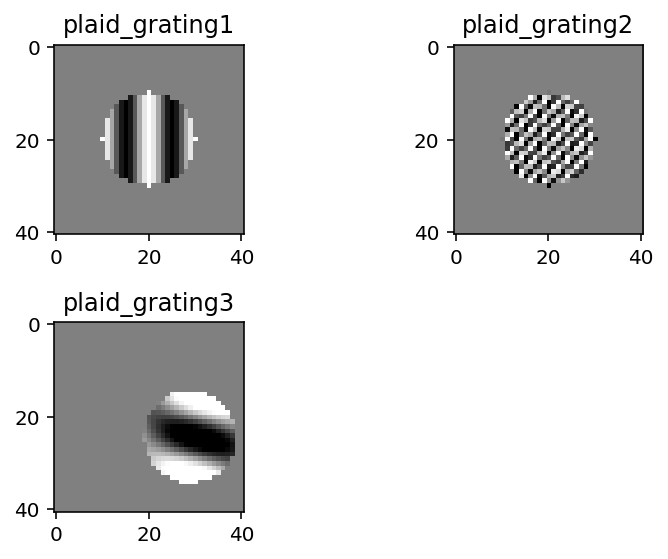

In [68]:
plt.subplot(221)
plt.imshow(plaid_grating1.stimulus_from_idx(0), cmap='gray', vmin=-1, vmax=1)
plt.title("plaid_grating1")

plt.subplot(222)
plt.imshow(plaid_grating2.stimulus_from_idx(0), cmap='gray', vmin=-1, vmax=1)
plt.title("plaid_grating2")

plt.subplot(223)
plt.imshow(plaid_grating3.stimulus_from_idx(0), cmap='gray', vmin=-1, vmax=1)
plt.title("plaid_grating3")

plt.tight_layout()